In [2]:
# prompt: install these
# import os
# from typing import TypedDict, List
# from langgraph.graph import StateGraph, END
# from langchain.prompts import PromptTemplate
# from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain.schema import HumanMessage
# from langchain_core.runnables.graph import MermaidDrawMethod
# from IPython.display import display, Image
# from dotenv import load_dotenv

!pip install langgraph
!pip install langchain
!pip install langchain-google-genai
!pip install python-dotenv



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.8
    Uninstalling msgpack-1.0.8:
      Succe

In [3]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from google.colab import userdata
import google.generativeai as genai
from dotenv import load_dotenv

In [10]:
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")
genai.configure(api_key=GEMINI_API_KEY)

In [11]:
class State(TypedDict):
  text:str
  classifications:list[str]
  entities:str
  summary:str

In [13]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",    google_api_key= GEMINI_API_KEY # Replace with your Google API key

)
print("LLM initialized.")

LLM initialized.


In [41]:
def classification(state:State):
  prompt = PromptTemplate(
      input_variables=["text"],
      template="Classify the following text into one of the categories: News, Blog, Research, or Other. Only return the category name.\n\nText: {text} :"
  )
  message= HumanMessage(content=prompt.format(text=state["text"]))
  classification_results = llm.predict_messages([message]).content.strip()
  return {"classifications":classification_results}

In [61]:
def entities(state: State):
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Only return the list of entities as a comma-separated list, without any additional labels or text.\n\nText: {text}"
    )
    message = HumanMessage(content=prompt.format(text=state["text"]))

    # Get the response from the language model
    response = llm.predict_messages([message]).content.strip()

    # Split the response into individual entities and clean them
    entities_result = [entity.strip() for entity in response.split(',') if entity.strip()]

    # Additional cleaning step to remove any remaining 'Entities:' prefix
    entities_result = [entity.replace('Entities:', '').strip() for entity in entities_result]

    return {"entities": entities_result}

In [59]:
def summary(state:State):
  prompt=PromptTemplate(
      input_variables=["text"],
      template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
  )
  message=HumanMessage(content=prompt.format(text=state["text"]))
  summarization_results = llm.predict_messages([message]).content.strip()
  return {"summary":summarization_results}
#

In [62]:
workflow=StateGraph(State)

workflow.add_node("Classification Node",classification)
workflow.add_node("Entities Extraction Node",entities)
workflow.add_node("Summary Node",summary)
workflow.set_entry_point("Classification Node")
workflow.add_edge("Classification Node","Entities Extraction Node")
workflow.add_edge("Entities Extraction Node","Summary Node")
workflow.add_edge("Summary Node",END)
graph = workflow.compile()

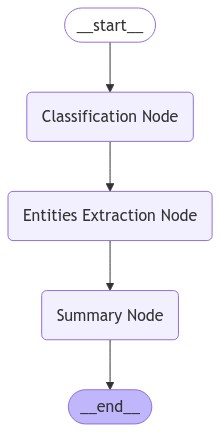

In [63]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [64]:
# prompt: i want to test the aboev graph

text = """OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes."""
initial_state = {"text": text}
result = graph.invoke(initial_state)
print("Classification :",result["classifications"])
print("Entities :",result["entities"])
print("Summary :",result["summary"])


Classification : News
Entities : ['OpenAI', 'GPT-4', 'GPT-3']
Summary : OpenAI's GPT-4 is a powerful, human-level multimodal AI model designed for safety, efficiency, and public research access.
